# Scanpy のインストール

In [ ]:
! pip3 install 'scanpy[leiden]'

# ライブラリのロード

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

# テストデータのインストール

In [ ]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

# 設定

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# ファイルの読み込み

In [ ]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results


In [ ]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


# adata (AnnData) について

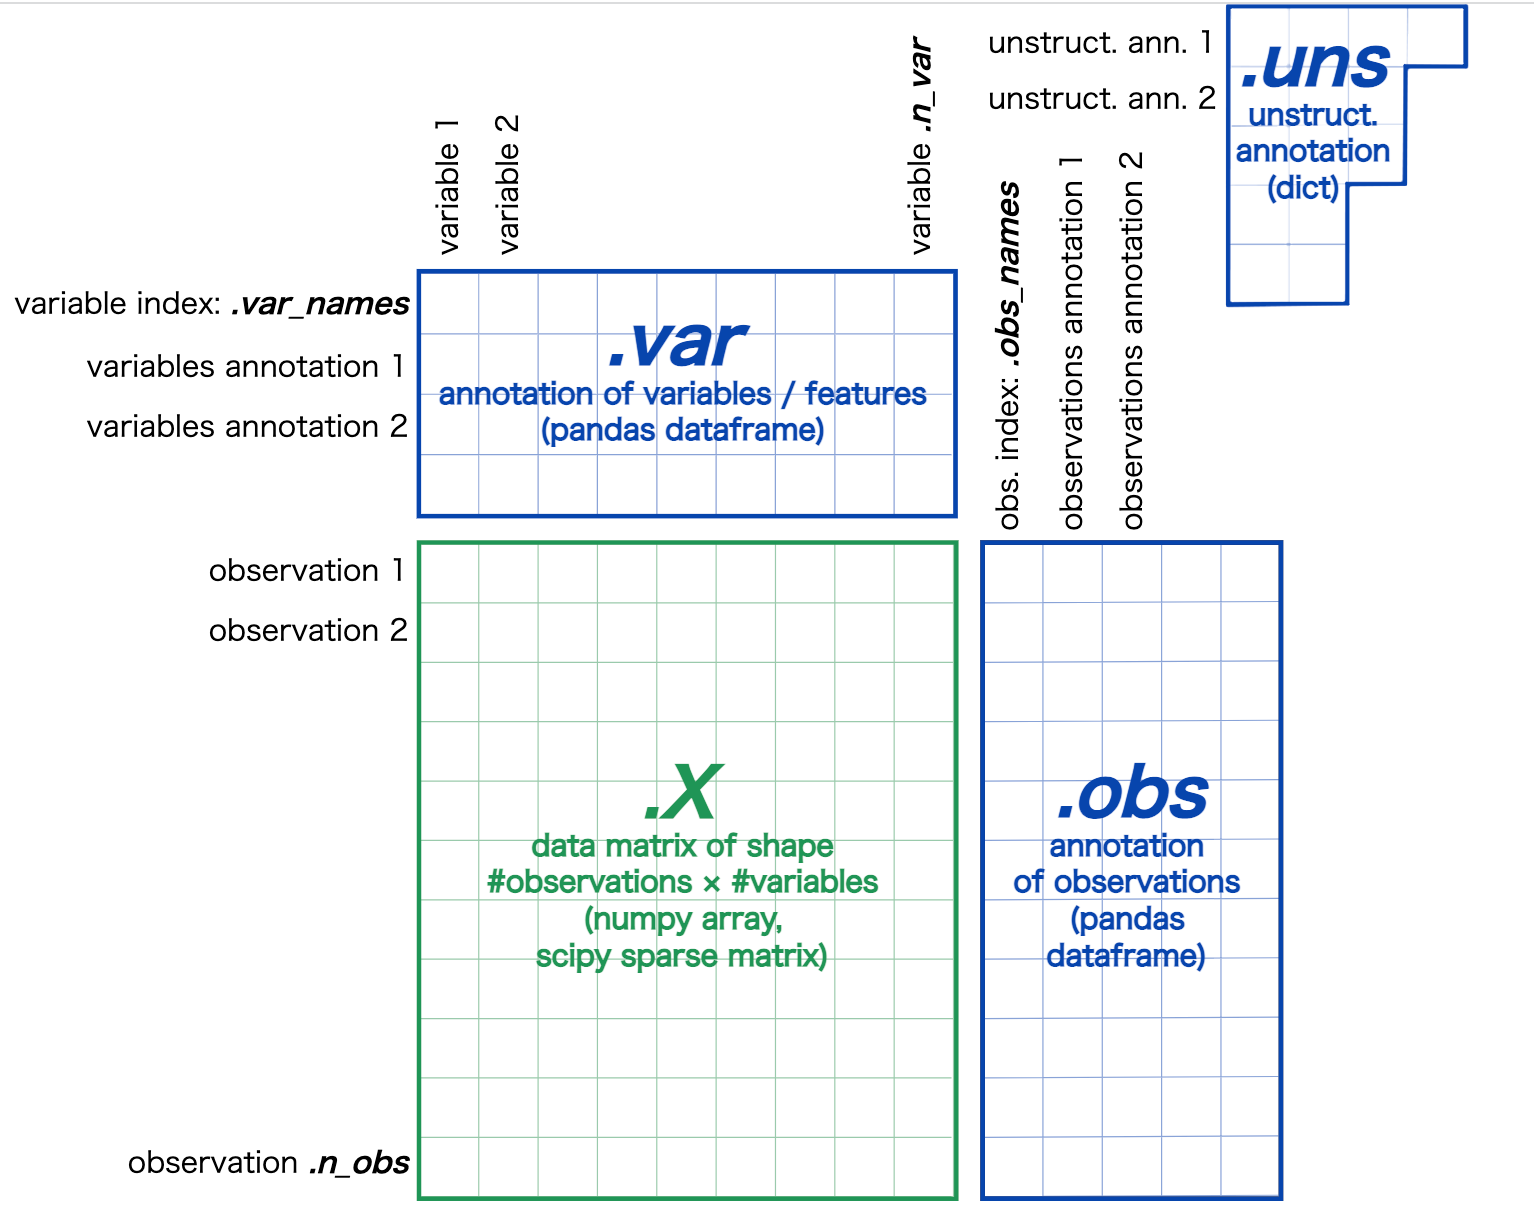

In [ ]:
adata


In [ ]:
# どんな attribute を持っているか
adata.__dict__.keys()

In [ ]:
adata.__dict__

# まずどんな遺伝子が多いか眺めてみる

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )


# 細胞と遺伝子をフィルタする

In [ ]:
adata

In [ ]:
sc.pp.filter_cells(adata, min_genes=300)


In [ ]:
adata

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)


In [ ]:
adata

# ミトコンドリア遺伝子の量を眺める

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.


In [ ]:

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# 発現遺伝子数が多すぎる細胞やミトコンドリアのカウントが多い遺伝子を除く

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# 細胞間でのカウントの違いを補正する

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)


# カウントをログ変換する

In [ ]:
sc.pp.log1p(adata)


# 高変動遺伝子 (highly-variable genes) を抽出する

In [ ]:
# Identify highly-variable genes.

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


In [ ]:
sc.pl.highly_variable_genes(adata)


# 高変動遺伝子のみを用いて次元圧縮をする

In [ ]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression
# for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

adata.raw = adata

In [ ]:
adata

In [ ]:
adata = adata[:, adata.var.highly_variable]


In [ ]:
adata

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


In [ ]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.

sc.pp.scale(adata, max_value=10)


## 主成分分析（PCA）

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')


In [ ]:
sc.pl.pca(adata, color='CST3')


In [ ]:
sc.pl.pca(adata, color='TCF7')


In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)


In [ ]:
adata.write(results_file)


# 近傍グラフを計算する

> インデントされたブロック




In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


# UMAP

In [ ]:
sc.tl.umap(adata)


In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


## Leidenクラスタリング

In [ ]:
sc.tl.leiden(adata)


In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


In [ ]:
adata.write(results_file)


## クラスターごとに特徴的な遺伝子を抽出する

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata = sc.read(results_file)


In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:

adata.uns['log1p']["base"] = None # To avoid error (https://github.com/scverse/scanpy/issues/2239)

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [ ]:
adata = sc.read(results_file)


In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')


In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


# 既知のマーカー遺伝子の発現を調べる

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']


In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);


# データを保存する

In [ ]:
# During the course of this analysis, the AnnData accumlated the following annotations.
adata


In [ ]:
adata.raw

In [ ]:
adata.raw.__dict__

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')
